In [1]:
%load_ext autoreload
%autoreload 2

# Exploratory data analysis

In [2]:
from common import scale_norm
import numpy as np
from functools import partial
import jax
import itertools
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import umap
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
import plotly.express as px
from scipy.cluster.hierarchy import linkage, fcluster
import matplotlib.gridspec
from matplotlib import font_manager
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize

from synbio_morpher.utils.results.analytics.timeseries import calculate_adaptation
from synbio_morpher.utils.results.analytics.naming import get_true_interaction_cols
from synbio_morpher.utils.data.data_format_tools.common import load_json_as_dict
from evoscaper.utils.preprocess import make_datetime_str
from evoscaper.utils.visualise import create_network_inset, make_nx_weights, make_sort_hue
from evoscaper.utils.evolution import calculate_ruggedness_from_perturbations

from common import set_theme

set_theme(font_scale=1.2)

PALETTE = 'viridis'



In [3]:
top_write_dir = os.path.join('data', '10_eda', make_datetime_str())
os.makedirs(top_write_dir, exist_ok=True)

# Load Data

In [4]:
# fn = '../data/raw/summarise_simulation/2024_11_21_144918/tabulated_mutation_info.csv'
# fn = '../data/raw/summarise_simulation/2024_11_21_160955/tabulated_mutation_info.csv'
# fn = '../data/raw/summarise_simulation/2024_12_05_210221/tabulated_mutation_info.csv'
fn_sim = './data/simulate_circuits/2025_01_29__18_12_38/tabulated_mutation_info.json'
fn = './data/simulate_circuits/2025_02_11__13_56_51/tabulated_mutation_info.json'
# fn_sim = 'data/simulate_circuits/2025_02_01__00_22_38/tabulated_mutation_info.json'

dir_ruggedness = 'data/07_ruggedness/2025_02_07__15_33_55'
ruggedness = np.load(os.path.join(dir_ruggedness, 'ruggedness.npy'))
analytics = load_json_as_dict(os.path.join(dir_ruggedness, 'analytics.json'))
resimulate_analytics = True

# fn_test_data = '../data/raw/summarise_simulation/2023_07_17_222747/tabulated_mutation_info.csv'
# data = pd.concat([pd.read_csv(fn), pd.read_csv(fn_test_data)])
data = pd.read_json(fn) if fn.endswith('.json') else pd.read_csv(fn)
data_sim = pd.read_json(fn_sim) if fn_sim.endswith('.json') else pd.read_csv(fn_sim)
len(data)

2579790

In [5]:
# from synbio_morpher.utils.data.data_format_tools.common import load_json_as_dict, write_json
# sns.set_style('whitegrid')

rn = {'sensitivity_wrt_species-6': 'sensitivity',
      'precision_wrt_species-6': 'precision',
      'response_time_wrt_species-6': 'response_time'}

for k, v in rn.items():
    if k in analytics:
        print('renaming', k, 'to', v)
        analytics[v] = analytics.pop(k)
# analytics = write_json(analytics, os.path.join(dir_ruggedness, 'analytics.json'), overwrite=True)


renaming sensitivity_wrt_species-6 to sensitivity
renaming precision_wrt_species-6 to precision
renaming response_time_wrt_species-6 to response_time


In [6]:
resimulate_analytics = True
objective_col = 'Log sensitivity'
output_species = ['RNA_2']
n_species = 3
cols_e_og = get_true_interaction_cols(data, 'energies', remove_symmetrical=True)
cols_e = [r'$k_{' + str(i) + str(j) + '}$' for i, j in sorted(set([tuple(sorted(i)) for i in itertools.product(np.arange(n_species) + 1, np.arange(n_species) + 1)]))]
print({eog: enew for eog, enew in zip(cols_e_og, cols_e)})
data = data.rename(columns={eog: enew for eog, enew in zip(cols_e_og, cols_e)})
data_sim = data_sim.rename(columns={eog: enew for eog, enew in zip(cols_e_og, cols_e)})
n_interactions = len(cols_e)
filt = data['sample_name'].isin(output_species)
output_idx = -1

analytic_perturbed = np.array(analytics[objective_col])
analytic_perturbed = analytic_perturbed.reshape(
    -1, n_interactions + resimulate_analytics, ruggedness.shape[-1])


def split_pert_og(pert):
    return pert[:, -1], pert[:, :-1]


if resimulate_analytics:
    analytic_og, analytic_perturbed = split_pert_og(analytic_perturbed)
else:
    analytic_og = data[objective_col].values

{'energies_0-0': '$k_{11}$', 'energies_0-1': '$k_{12}$', 'energies_0-2': '$k_{13}$', 'energies_1-1': '$k_{22}$', 'energies_1-2': '$k_{23}$', 'energies_2-2': '$k_{33}$'}


# Load ruggedness

In [ ]:
analytics['adaptation'] = calculate_adaptation(
    np.array(analytics['sensitivity']), np.array(analytics['precision']), alpha=2)

og_sensitivity, pert_sensitivity = split_pert_og(np.array(analytics['Log sensitivity']).reshape(
    -1, n_interactions + resimulate_analytics, ruggedness.shape[-1]))
og_precision, pert_precision = split_pert_og(np.array(analytics['Log precision']).reshape(
    -1, n_interactions + resimulate_analytics, ruggedness.shape[-1]))
og_adaptation, pert_adaptation = split_pert_og(np.array(analytics['adaptation']).reshape(
    -1, n_interactions + resimulate_analytics, ruggedness.shape[-1]))
og_overshoot, pert_overshoot = split_pert_og(np.array(analytics['overshoot']).reshape(
    -1, n_interactions + resimulate_analytics, ruggedness.shape[-1]))
og_resptime, pert_resptime = split_pert_og(np.array(analytics['response_time']).reshape(
    -1, n_interactions + resimulate_analytics, ruggedness.shape[-1]))

eps_perc = - 1e-2
eps = eps_perc * np.abs(data[cols_e].to_numpy()).max()

ruggedness_adaptation = jax.vmap(partial(calculate_ruggedness_from_perturbations, eps=eps))(
    pert_adaptation, og_adaptation[:, None, :])

In [ ]:
data_seq = pd.DataFrame()

for k, v in analytics.items():
    og_k, pert_k = split_pert_og(np.array(v).reshape(
        -1, n_interactions + resimulate_analytics, ruggedness.shape[-1]))
    data_seq[k] = og_k[..., output_idx]
    
# data_seq['ruggedness_adaptation'] = ruggedness_adaptation[..., output_idx]
# data_seq['ruggedness_sensitivity'] = ruggedness[..., output_idx]

# Visualise

/tmp/ipykernel_255231/1774605884.py:18: RuntimeWarning: divide by zero encountered in log10
  lambda x: np.where(x == 0, np.nan, np.log10(x))).apply(lambda x: np.round(x, 2))


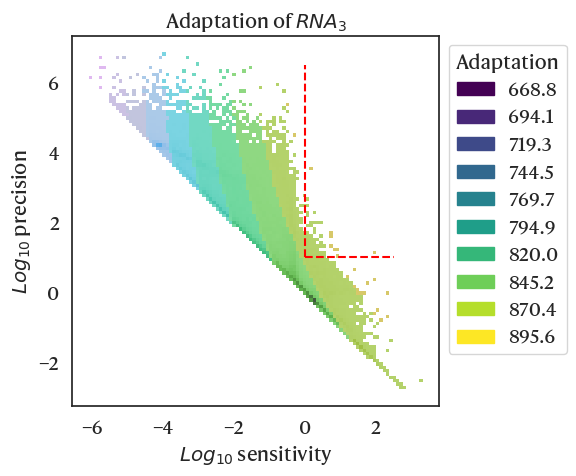

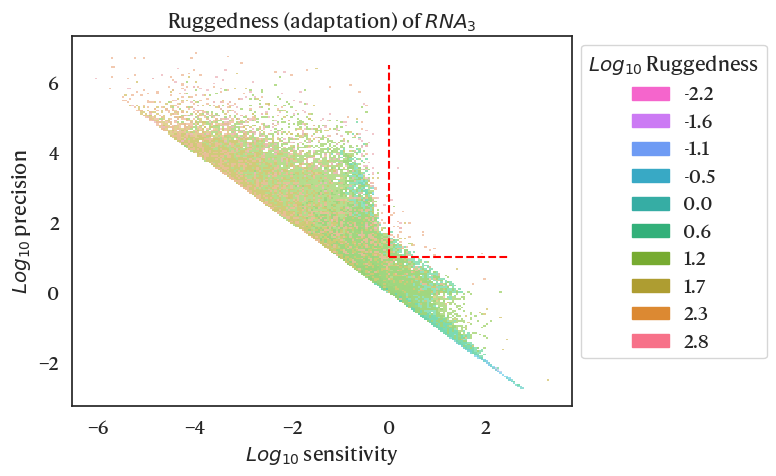

In [ ]:
df = pd.DataFrame()
for k, v in zip(['Log sensitivity', 'Log precision', 'adaptation', 'response_time', 'ruggedness_adaptation', 'ruggedness_sensitivity', 'overshoot'],
                [og_sensitivity, og_precision, og_adaptation, og_resptime, ruggedness_adaptation, ruggedness, og_overshoot]):
    df[k] = v[..., output_idx]
filt_df = ~df['Log sensitivity'].isna() & ~np.isinf(df['Log sensitivity']) & ~np.isinf(
    df['adaptation']) & (df['overshoot'] > 0)  # & (df['response_time'] < 0.8*df['response_time'].max())
df = df[filt_df]
df['adaptation_bin'] = pd.cut(df['adaptation'], bins=10)
df['Adaptation'] = df['adaptation_bin'].apply(lambda x: x.mid).astype(
    np.float32).apply(lambda x: np.round(x, 1))
df['ruggedness_adaptation_bin'] = pd.cut(df['ruggedness_adaptation'], bins=10)
# df['ruggedness_sensitivity_bin'] = pd.cut(df['ruggedness_sensitivity'], bins=5)
# df['ruggedness_sensitivity_bins'] = df['ruggedness_sensitivity_bin'].apply(lambda x: x.mid).astype(np.float32)
# df['Log10 Ruggedness'] = df['ruggedness_sensitivity_bins'].apply(np.log10).apply(lambda x: np.round(x, 2))

nbins = 10
df[r'$Log_{10}$ Ruggedness (adaptation)'] = df['ruggedness_adaptation'].apply(
    lambda x: np.where(x == 0, np.nan, np.log10(x))).apply(lambda x: np.round(x, 2))
df[r'$Log_{10}$ Ruggedness'] = pd.cut(df[r'$Log_{10}$ Ruggedness (adaptation)'], bins=nbins)
df[r'$Log_{10}$ Ruggedness'] = df[r'$Log_{10}$ Ruggedness'].apply(
    lambda x: np.round(x.mid, 1)).astype(np.float32)

fig, ax_0 = plt.subplots(1, 1, figsize=(6,  5))
x_col = 'Log sensitivity'
y_col = 'Log precision'
g = sns.histplot(df, x=x_col, y=y_col, hue='Adaptation', palette='viridis', ax=ax_0, bins=100)
sns.move_legend(g, 'upper left', bbox_to_anchor=(1, 1))
ax_0.set_title(f'Adaptation of $RNA_3$')
ax_0.set_xlabel(x_col.replace('Log', f'$Log_{{10}}$'))
ax_0.set_ylabel(y_col.replace('Log', f'$Log_{{10}}$'))
ax_0.plot([0, 2.5], [1, 1], color='red', linestyle='--')
ax_0.plot([0, 0], [1, 6.5], color='red', linestyle='--')

plt.tight_layout()
plt.savefig(os.path.join(top_write_dir, 'scatter_sp_adapt.svg'))
plt.savefig(os.path.join(top_write_dir, 'scatter_sp_adapt.png'), dpi=300, transparent=True)

fig, ax_1 = plt.subplots(1, 1, figsize=(8,  5))
# g = sns.scatterplot(df.sort_values(by=r'$Log_{10}$ Ruggedness'), x='Log sensitivity', y='Log precision', hue=np.log10(df['ruggedness_adaptation']), palette='plasma', ax=ax_1, alpha=0.2, s=10)
g = sns.histplot(df.sort_values(by=r'$Log_{10}$ Ruggedness', ascending=False), x=x_col, y=y_col,
                 hue=r'$Log_{10}$ Ruggedness', palette=sns.color_palette("husl", nbins)[::-1], ax=ax_1, alpha=0.8, bins=200)
sns.move_legend(g, 'upper left', bbox_to_anchor=(1, 1))
ax_1.set_title(f'Ruggedness (adaptation) of $RNA_3$')
ax_1.set_xlabel(x_col.replace('Log', f'$Log_{{10}}$'))
ax_1.set_ylabel(y_col.replace('Log', f'$Log_{{10}}$'))
ax_1.plot([0, 2.5], [1, 1], color='red', linestyle='--')
ax_1.plot([0, 0], [1, 6.5], color='red', linestyle='--')

plt.tight_layout()
plt.savefig(os.path.join(top_write_dir, 'scatter_sp_rugged.png'),
            dpi=300, transparent=True)
# plt.savefig(os.path.join(top_write_dir, 'scatter_sp_rugged.svg'))

/tmp/ipykernel_255231/634266198.py:32: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


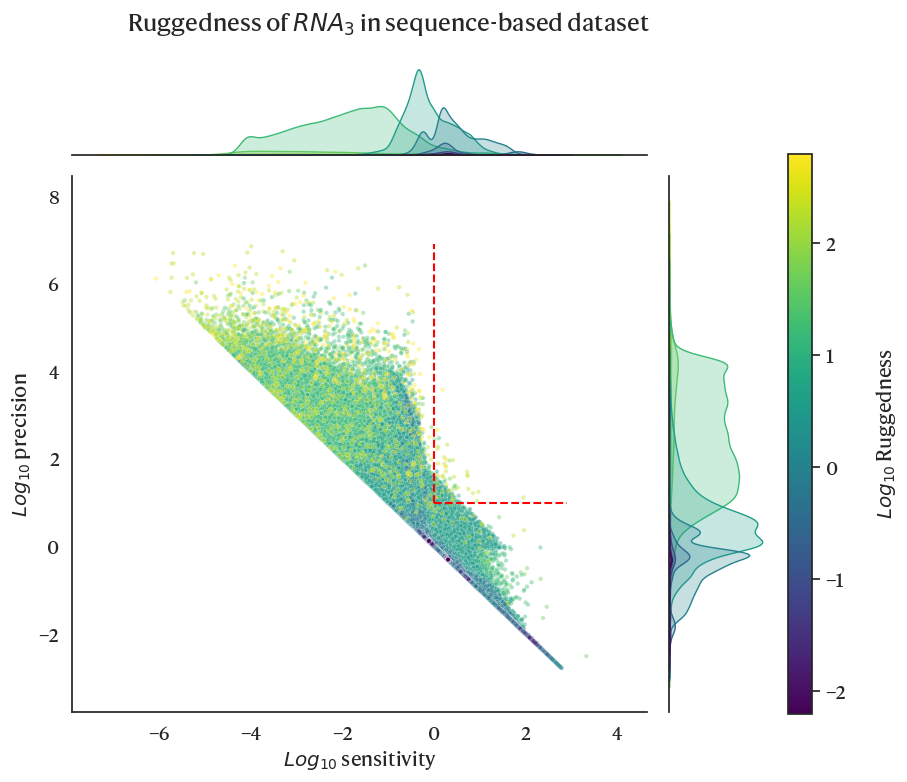

In [ ]:
hue = r'$Log_{10}$ Ruggedness'
use_colorbar = True
idxs_show = make_sort_hue(df[hue].values, sort=True, sort_flip_prop=100)
df.rename(columns={'Log sensitivity': r'$Log_{10}$ sensitivity', 'Log precision': r'$Log_{10}$ precision'}, inplace=True)
g = sns.jointplot(df.iloc[idxs_show], kind='scatter',
                  x=r'$Log_{10}$ sensitivity', y=r'$Log_{10}$ precision', hue=hue, palette='viridis',
                  alpha=0.4, s=10, legend=not(use_colorbar),
                  height=8)

if not(use_colorbar):
    # Set legend alpha and title and size
    for line in g.ax_joint.legend().get_lines():
        line.set(alpha=1.0, markersize=5)
    g.ax_joint.legend_.set_title(hue)

else:
    # Add a colorbar instead of the legend
    norm = Normalize(vmin=df.iloc[idxs_show][hue].min(),
                    vmax=df.iloc[idxs_show][hue].max())
    sm = ScalarMappable(cmap='viridis', norm=norm)
    sm.set_array([])

    # Add colorbar to the figure
    cax = g.figure.add_axes([1., 0.1, 0.03, 0.7])  # [x, y, width, height]
    cbar = g.figure.colorbar(sm, cax=cax)
    cbar.set_label(hue, rotation=90, labelpad=20)

g.ax_joint.plot([0, 2.9], [1, 1], color='red', linestyle='--')
g.ax_joint.plot([0, 0], [1, 6.9], color='red', linestyle='--')

plt.suptitle(f'Ruggedness of $RNA_3$ in sequence-based dataset')
plt.tight_layout()
plt.savefig(os.path.join(top_write_dir, 'jointplot_rugged.png'),
            dpi=300, transparent=True, bbox_inches='tight')
# plt.savefig(os.path.join(top_write_dir, 'jointplot_rugged.svg'), bbox_inches='tight')

In [ ]:
# if 'adaptation' not in data_sim:
#     data_sim['adaptation'] = calculate_adaptation(
#         np.array(data_sim['sensitivity']), np.array(data_sim['precision']), alpha=2)

# filt_sim = ~data_sim['Log sensitivity'].isna() & ~np.isinf(data_sim['Log sensitivity']) & ~np.isinf(
#     data_sim['adaptation']) & data_sim['sample_name'].isin(output_species) # & (data_sim['overshoot'] > 0)

# nbins = 10
# data_sim['Log10 Ruggedness'] = pd.cut(data_sim['Log ruggedness (adaptation)'], bins=nbins)
# data_sim['Log10 Ruggedness'] = data_sim['Log10 Ruggedness'].apply(
#     lambda x: np.round(x.mid, 1)).astype(np.float32)
# # hue = 'Log ruggedness (adaptation)'
# hue = 'Log10 Ruggedness'
# idxs_show = make_sort_hue(data_sim[filt_sim][hue].values, sort=True, sort_flip_prop=100)
# g = sns.jointplot(data_sim[filt_sim].iloc[idxs_show], kind='scatter',
#                   x='Log sensitivity', y='Log precision', hue=hue, palette='viridis',
#                   alpha=0.5, s=10, legend=True,
#                   height=8)

# # Set legend alpha and title and size
# for line in g.ax_joint.legend().get_lines():
#     line.set(alpha=1.0, markersize=5)
# g.ax_joint.legend_.set_title(hue)

# g.ax_joint.plot([0, 2.9], [1, 1], color='red', linestyle='--')
# g.ax_joint.plot([0, 0], [1, 6.9], color='red', linestyle='--')

# plt.savefig(os.path.join(top_write_dir, 'jointplot_rugged_sim.png'),
#             dpi=300, transparent=True)
# plt.tight_layout()

In [ ]:
# data['Log sensitivity'] = np.log10(data['sensitivity'])
# data['Log precision'] = np.log10(data['precision'])
# data['adaptation'] = calculate_adaptation(data['sensitivity'].to_numpy(), data['precision'].to_numpy())
# data['adaptation_bin'] = pd.cut(data['adaptation'], bins=10)
# data['adaptation_bins'] = data['adaptation_bin'].apply(lambda x: x.mid).astype(float)
# filt = (data['sample_name'] == 'RNA_2') & (data['response_time'] < 0.8*data['response_time'].max())
# # data['response_time_bin'] = pd.cut(data['response_time'], bins=10)
# # data['response_time_bins'] = data['response_time_bin'].apply(lambda x: x.mid).astype(float)

# fig, axs = plt.subplots(1, 2, figsize=(12, 4))
# g = sns.histplot(data[filt], x='Log sensitivity', y='Log precision', hue='adaptation_bin', palette='viridis', ax=axs[0])
# sns.move_legend(g, 'upper left', bbox_to_anchor=(1, 1))
# axs[0].set_title('Adaptation of RNA_2')

# g = sns.histplot(data[filt], x='Log sensitivity', y='Log precision', hue='adaptation_bin', palette='viridis', ax=axs[1])
# sns.move_legend(g, 'upper left', bbox_to_anchor=(1, 1))
# axs[1].set_title('Ruggedness of RNA_2')

# plt.tight_layout()

/tmp/ipykernel_255231/1610505419.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sim2['Adaptation norm'] = scale_norm(data_sim2['Adaptation'], key='Adaptation', data=data_sim, vmin=0, vmax=1).round(2)


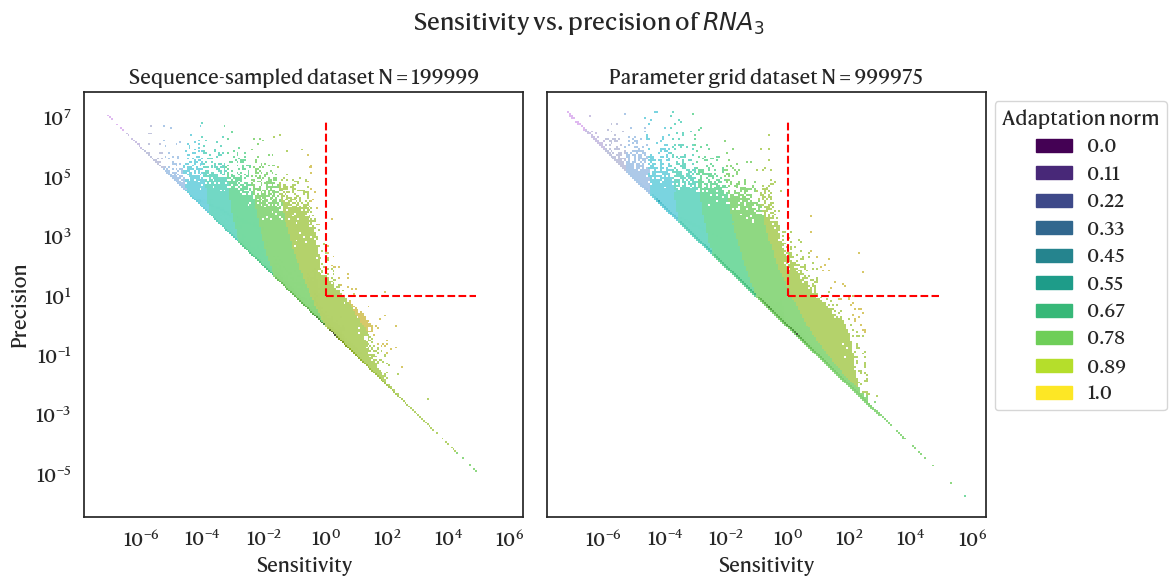

In [ ]:
# Add adaptation bins
def add_adaptation_bins(df):
    df.rename(columns={'Sensitivity': 'sensitivity', 'Precision': 'precision'}, inplace=True)
    df['Log10 Sensitivity'] = np.log10(df['sensitivity']).round(2)
    df['Log10 Precision'] = np.log10(df['precision']).round(2)
    if 'adaptation' not in df:
        df['adaptation'] = calculate_adaptation(
            np.array(df['sensitivity']), np.array(df['precision']), alpha=2)
    df['Adaptation'] = pd.cut(df['adaptation'], bins=10)
    df['Adaptation'] = df['Adaptation'].apply(lambda x: x.mid).astype(
        np.float32).apply(lambda x: np.round(x, 0))
    return df


filt_seq = (data_seq['overshoot'] >= 0)
filt_sim = (data_sim['sample_name'] == 'RNA_2') # & (data_sim['overshoot'] > 0)
data_seq = add_adaptation_bins(data_seq)
data_sim = add_adaptation_bins(data_sim)



fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharex=True, sharey=True)
axs[0].set(xscale="log", yscale="log")
axs[1].set(xscale="log", yscale="log")

data_seq.rename(columns={'sensitivity': 'Sensitivity', 'precision': 'Precision'}, inplace=True)
data_seq['Adaptation norm'] = scale_norm(data_seq['Adaptation'], key='Adaptation', data=data_seq, vmin=0, vmax=1).round(2)
sns.histplot(data_seq[filt_seq], x='Sensitivity', y='Precision', hue='Adaptation norm', palette='viridis', bins=200, 
             ax=axs[0], log_scale=(True, True), legend=False)
# axs[0].hlines(1, *axs[0].get_xlim(), color='r')
# axs[0].vlines(10, *axs[0].get_ylim(), color='r')
axs[0].plot([1, np.power(10, 4.9)], [10, 10], color='red', linestyle='--')
axs[0].plot([1, 1], [10, np.power(10, 6.9)], color='red', linestyle='--')
# axs[0].grid(True, which="both", ls="-", alpha=0.5)
# axs[0].grid(True, which="minor", ls=":", alpha=0.3)
axs[0].set_title(f'Sequence-sampled dataset N = {len(data_seq[filt_seq])}')
data_sim.rename(columns={'sensitivity': 'Sensitivity', 'precision': 'Precision'}, inplace=True)
data_sim2 = data_sim[filt_sim & data_sim['Adaptation'].notna()]
# data_sim2['Adaptation'] = data_sim2['Adaptation'] #.apply(int) # .apply(str)
data_sim2['Adaptation norm'] = scale_norm(data_sim2['Adaptation'], key='Adaptation', data=data_sim, vmin=0, vmax=1).round(2)
g = sns.histplot(data_sim2, x='Sensitivity', y='Precision', hue='Adaptation norm', palette='viridis',
                 bins=200, ax=axs[1], log_scale=(True, True), legend=True)
# sns.move_legend(g, 'lower left', bbox_to_anchor=(0, 0))
sns.move_legend(g, 'upper left', bbox_to_anchor=(1, 1))
axs[1].plot([1, np.power(10, 4.9)], [10, 10], color='red', linestyle='--')
axs[1].plot([1, 1], [10, np.power(10, 6.9)], color='red', linestyle='--')
axs[1].set_title(f'Parameter grid dataset N = {len(data_sim2)}')

plt.suptitle(f'Sensitivity vs. precision of $RNA_3$')

plt.tight_layout()
plt.savefig(os.path.join(top_write_dir, 'scatter_sp_ogdata.png'), dpi=300, transparent=True)
plt.savefig(os.path.join(top_write_dir, 'scatter_sp_ogdata.svg'), bbox_inches='tight')


In [ ]:
exclude_cols = ['RMSE', 'num_interacting', 'num_self_interacting', 'circuit_name']
numerical_columns = data[data.columns.difference(exclude_cols)].select_dtypes(include=[np.number]).columns.tolist()
len(numerical_columns)

39

In [ ]:
if 'Log sensitivity' not in data.columns:
    data['Log sensitivity'] = np.where(np.isinf(np.log10(data['sensitivity'])), np.nan, np.log10(data['sensitivity']))
if 'Log precision' not in data.columns:
    data['Log precision'] = np.where(np.isinf(np.log10(data['precision'])), np.nan, np.log10(data['precision']))
    
data['Log sensitivity bin'] = pd.cut(data['Log sensitivity'], bins=10)
data['Log sensitivity bin'] = data['Log sensitivity bin'].apply(lambda x: np.round(x.mid, 1)).astype(float)

combos_e = list(itertools.combinations(cols_e, 2))
filt_d = (data['sample_name'] == 'RNA_2') & (data['Log sensitivity'] > -5) & (data['Log sensitivity'] < 3) & (~data['Log precision'].isna())


# Adaptable motifs

In [ ]:
sns.blend_palette(['#ff9f9b', '#ffb482', '#fffea3', '#c1f6b8', '#a0e7e0', '#b9d3ee', '#d6a4ef', '#ff77a7'], n_colors=9)


[(np.float64(1.0),
  np.float64(0.6235294117647059),
  np.float64(0.6078431372549019)),
 (np.float64(1.0),
  np.float64(0.6958708189158016),
  np.float64(0.5217224144559784)),
 (np.float64(1.0),
  np.float64(0.9255209534794311),
  np.float64(0.6077508650519031)),
 (np.float64(0.8455363321799307),
  np.float64(0.9761476355247981),
  np.float64(0.6915340253748559)),
 (np.float64(0.6903806228373701),
  np.float64(0.9344867358708189),
  np.float64(0.8021530180699732)),
 (np.float64(0.6658977316416763),
  np.float64(0.8751249519415608),
  np.float64(0.8999615532487505)),
 (np.float64(0.7562629757785468),
  np.float64(0.7775778546712802),
  np.float64(0.9343944636678201)),
 (np.float64(0.8631757016532103),
  np.float64(0.6168396770472895),
  np.float64(0.8951787773933102)),
 (np.float64(1.0),
  np.float64(0.4666666666666667),
  np.float64(0.6549019607843137))]

/usr/local/lib/python3.10/dist-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/tmp/ipykernel_255231/2552654201.py:69: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


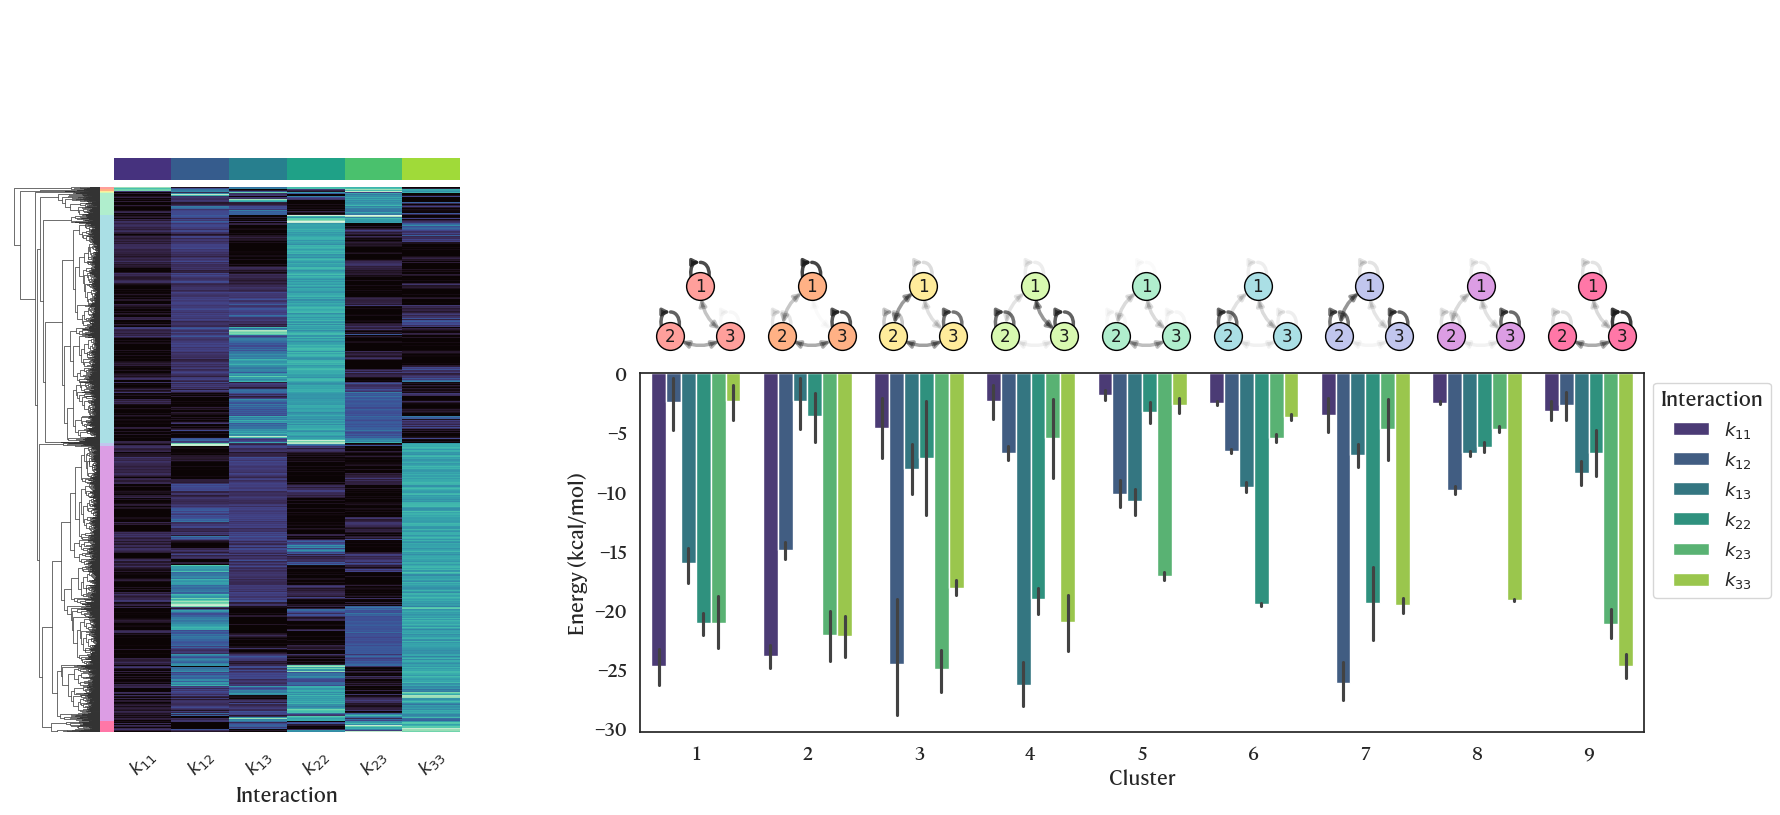

In [ ]:
# sns.set_context("notebook", font_scale=1.2)
n_clusters = 9
custom_palette = sns.blend_palette(['#ff9f9b', '#ffb482', '#fffea3', '#c1f6b8', '#a0e7e0', '#b9d3ee', '#d6a4ef', '#ff77a7'], n_colors=n_clusters)
figsize = (18, 8)

f_filt_adapt0 = lambda d: (d['Log sensitivity'] > 0) & (d['Log precision'] > 1) & (
    np.isfinite(d['Log sensitivity'])) & (np.isfinite(d['Log precision']))
df_plot = pd.concat([data[f_filt_adapt0(data)], data_sim[f_filt_adapt0(data_sim)]], ignore_index=True)

g = sns.clustermap(data=df_plot[cols_e], col_cluster=False)
row_linkage = g.dendrogram_row.linkage
clusters = fcluster(row_linkage, t=n_clusters, criterion='maxclust')
df_plot['Cluster'] = clusters
lut = dict(zip(sorted(df_plot['Cluster'].unique()),
           custom_palette.as_hex()))
        #    sns.color_palette('Spectral', n_clusters).as_hex()))
row_colors = df_plot['Cluster'].map(lut).to_numpy()
col_colors = sns.color_palette('viridis', len(cols_e)).as_hex()

plt.close()
del g


g = sns.clustermap(data=df_plot[cols_e],  # .rename(columns={c: ci for c, ci in zip(cols_e_bins, cols_e)}),
                   # 'label': 'Interaction energy differences'},
                   # cbar_kws={'orientation': 'vertical', 'shrink': 0.2},
                   cmap='mako_r', col_cluster=False,
                   cbar_pos=None,  # (0, .2, .03, .4), #standard_scale=1,
                   figsize=figsize,
                   row_colors=row_colors,
                   col_colors=col_colors,
                   )
g.ax_heatmap.set_yticklabels([])
g.ax_heatmap.set_yticks([])
g.ax_heatmap.set_xticklabels(g.ax_heatmap.get_xticklabels()) #, fontsize=14)

g.ax_heatmap.set_xlabel('Interaction') #, fontsize=14)
g.ax_heatmap.set_xticklabels(cols_e, rotation=45)
g.gs.update(left=0.05, right=0.3)

gs2 = matplotlib.gridspec.GridSpec(4, 1, left=0.4)
ax2 = g.figure.add_subplot(gs2[1])
ax3 = g.figure.add_subplot(gs2[2:])

g2 = sns.barplot(data=df_plot.melt(id_vars=['Cluster'],
                                   value_vars=cols_e,
                                   value_name='Energy (kcal/mol)',
                                   var_name='Interaction').sort_values('Interaction'),
                 x='Cluster', y='Energy (kcal/mol)', hue='Interaction',
                 ax=ax3, palette='viridis')
sns.move_legend(g2, "upper left", bbox_to_anchor=(1, 1)) #, fontsize=14)

# ax2.set_title('Interactions per cluster')
ax2.set_axis_off()
pos = np.concatenate([(np.arange(n_clusters) / (n_clusters+1)) * 1.11 - 0.39,
                     np.ones(n_clusters) * - 0.1]).reshape(2, -1).T
colors = custom_palette.as_hex()
# colors = sns.color_palette('Spectral', n_clusters).as_hex()
for i, c in enumerate(sorted(df_plot['Cluster'].unique())):
    fake_circuits_cluster = df_plot[df_plot['Cluster']
                                    == c][cols_e].values
    w = np.median(fake_circuits_cluster, axis=0)
    create_network_inset(fig, ax2,
                         pos=pos[i],
                         width=0.9, height=0.9, edge_weights=make_nx_weights(w, n_nodes=3,
                                                                             vmin=np.min(df_plot[cols_e]), vmax=np.max(df_plot[cols_e])),
                         node_color=colors[i], linewidth=2.5)

plt.tight_layout()
plt.savefig(os.path.join(
    top_write_dir, 'motifs_cluster_bars.png'), dpi=300, bbox_inches='tight', transparent=True)
# plt.savefig(os.path.join(
#     top_write_dir, 'motifs_cluster_bars.svg'), bbox_inches='tight')

/usr/local/lib/python3.10/dist-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/tmp/ipykernel_255231/4240423400.py:72: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


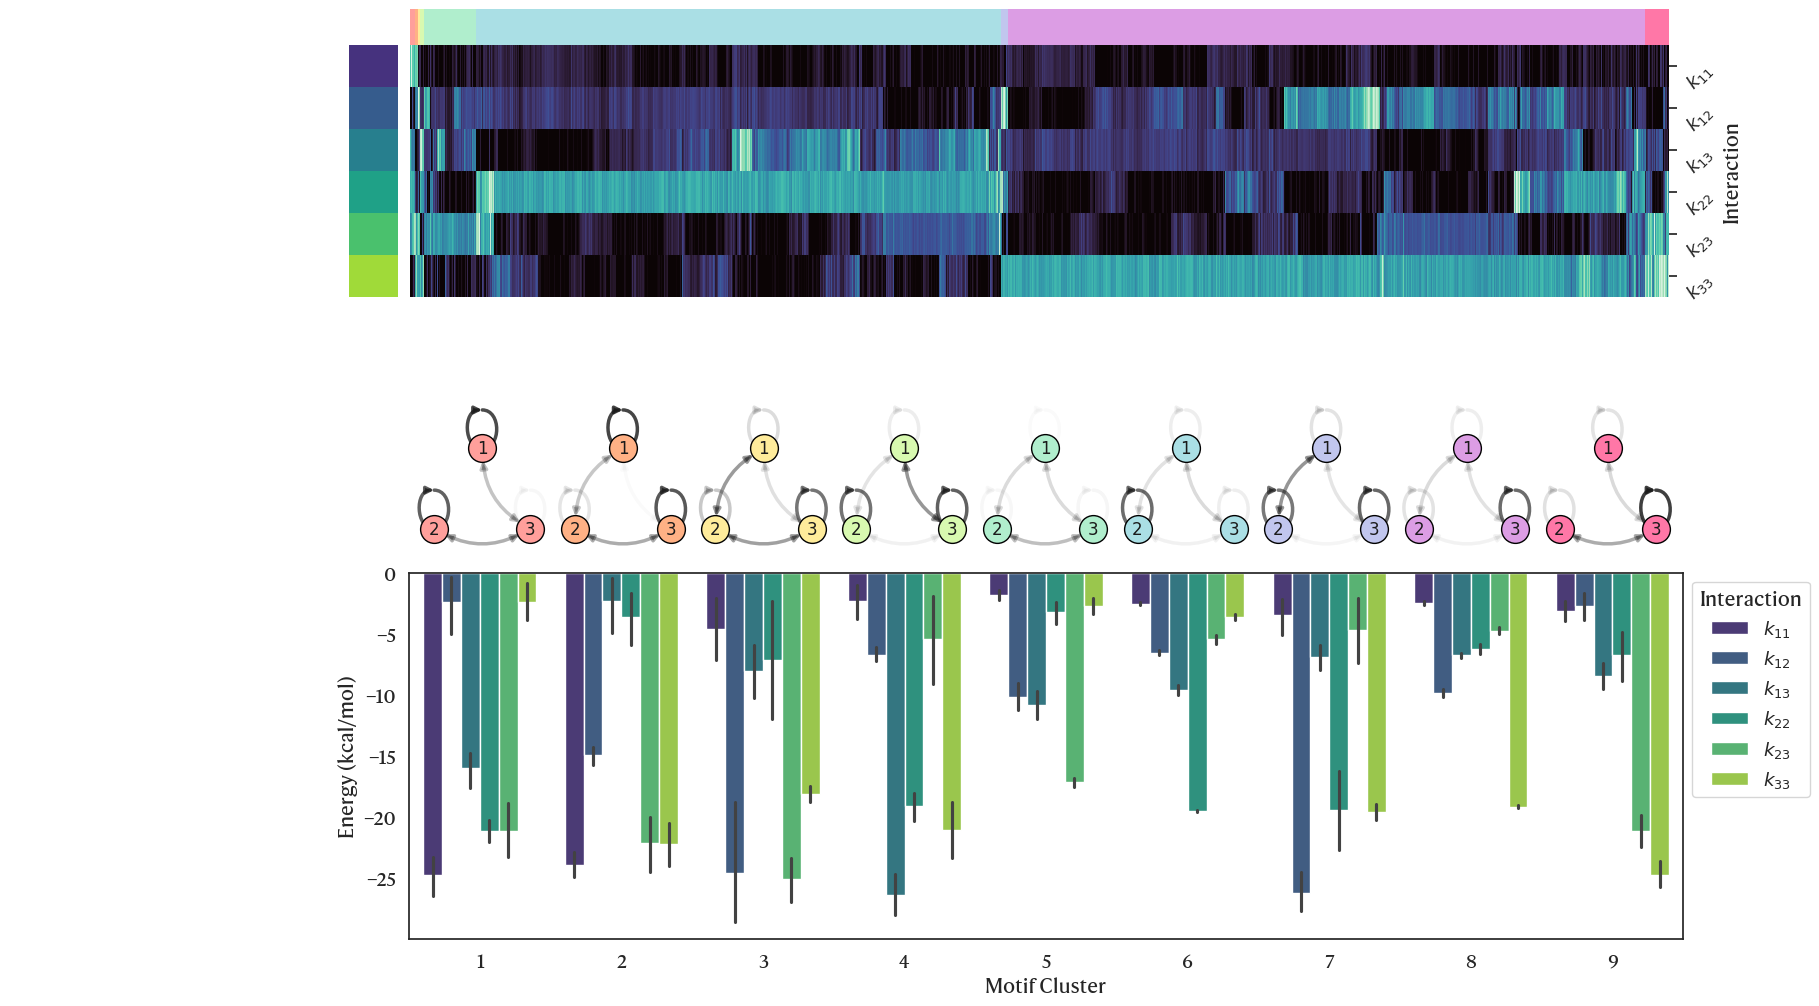

In [ ]:
def plot_clusters(f_filt, save_name, n_clusters = 6, figsize = (10, 9),
                  scaling_size = 0.9, scaling_width = 1.0, scaling_offset = 1.0):
    # sns.set_context("notebook", font_scale=1.4)
    custom_palette = sns.blend_palette(['#ff9f9b', '#ffb482', '#fffea3', '#c1f6b8', '#a0e7e0', '#b9d3ee', '#d6a4ef', '#ff77a7'], n_colors=n_clusters)
    # custom_palette = sns.blend_palette(['#ff9f9b', '#ffb482', '#fffea3', '#c1f6b8', '#a0e7e0', '#b9d3ee', '#d6a4ef', '#ff77a7'], n_colors=n_clusters + 1)

    df_plot = pd.concat([data[f_filt(data)], data_sim[f_filt(data_sim)]], ignore_index=True)

    g = sns.clustermap(data=df_plot[cols_e], col_cluster=False)
    row_linkage = g.dendrogram_row.linkage
    clusters = fcluster(row_linkage, t=n_clusters, criterion='maxclust')
    df_plot['Cluster'] = clusters
    lut = dict(zip(sorted(df_plot['Cluster'].unique()),
                   custom_palette.as_hex()))
    #    sns.color_palette('Spectral', n_clusters).as_hex()))
    col_colors = df_plot['Cluster'].map(lut).to_numpy()
    row_colors = sns.color_palette('viridis', len(cols_e)).as_hex()

    plt.close()
    del g

    g = sns.clustermap(data=df_plot[cols_e].T,
                       cmap='mako_r', row_cluster=False, 
                       cbar_pos=None,
                       figsize=figsize,
                       row_colors=row_colors,
                       col_colors=col_colors,
                       colors_ratio=[0.03, 0.1]
                       )
    
    g.ax_col_dendrogram.set_visible(False)
    
    g.ax_heatmap.set_xticklabels([])
    g.ax_heatmap.set_xticks([])

    g.ax_heatmap.set_ylabel('Interaction') 
    g.ax_heatmap.set_yticklabels(cols_e, rotation=45)
    g.gs.update(left=-0.235, right=0.95, bottom=0.6, top=0.9)

    # gs2 = matplotlib.gridspec.GridSpec(4, 1, left=0.05)
    # ax2 = g.figure.add_subplot(gs2[2])
    # ax3 = g.figure.add_subplot(gs2[3])
    gs2 = matplotlib.gridspec.GridSpec(3, 1, left=0.05)
    ax2 = g.figure.add_subplot(gs2[1])
    ax3 = g.figure.add_subplot(gs2[2])

    g2 = sns.barplot(data=df_plot.melt(id_vars=['Cluster'],
                                       value_vars=cols_e,
                                       value_name='Energy (kcal/mol)',
                                       var_name='Interaction').sort_values('Interaction'),
                     x='Cluster', y='Energy (kcal/mol)', hue='Interaction',
                     ax=ax3, palette='viridis')
    ax3.set_xlabel('Motif Cluster')
    sns.move_legend(g2, "upper left", bbox_to_anchor=(1, 1)) 

    ax2.set_axis_off()
    pos = np.concatenate([(np.arange(n_clusters) / (n_clusters+1)) * 1.2 * scaling_width - 0.39 * scaling_offset,
    # pos = np.concatenate([(np.arange(n_clusters) / (n_clusters+1)) * 1.11 - 0.39,
                          np.ones(n_clusters) * - 0.1]).reshape(2, -1).T
    colors = custom_palette.as_hex()
    # colors = sns.color_palette('Spectral', n_clusters).as_hex()
    for i, c in enumerate(sorted(df_plot['Cluster'].unique())):
        fake_circuits_cluster = df_plot[df_plot['Cluster']
                                        == c][cols_e].values
        w = np.median(fake_circuits_cluster, axis=0)
        create_network_inset(fig, ax2,
                             pos=pos[i],
                             width=scaling_size, height=scaling_size, edge_weights=make_nx_weights(w, n_nodes=3,
                                                                                 vmin=np.min(df_plot[cols_e]), vmax=np.max(df_plot[cols_e])),
                             node_color=colors[i], linewidth=2.5)

    plt.tight_layout()
    plt.savefig(os.path.join(
        top_write_dir, f'{save_name}.png'), dpi=300, bbox_inches='tight', transparent=True)
    # plt.savefig(os.path.join(
    #     top_write_dir, f'{save_name}.svg'), bbox_inches='tight')

    plt.show()

    return df_plot


df_plot = plot_clusters(f_filt_adapt0, 'motifs_cluster_bars_stacked', 
                        n_clusters=9, figsize = (14, 12),
                        scaling_size=0.7, scaling_width=0.92, scaling_offset=0.75)

### Plot subset of cluster motifs

/usr/local/lib/python3.10/dist-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/tmp/ipykernel_255231/3726264225.py:73: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


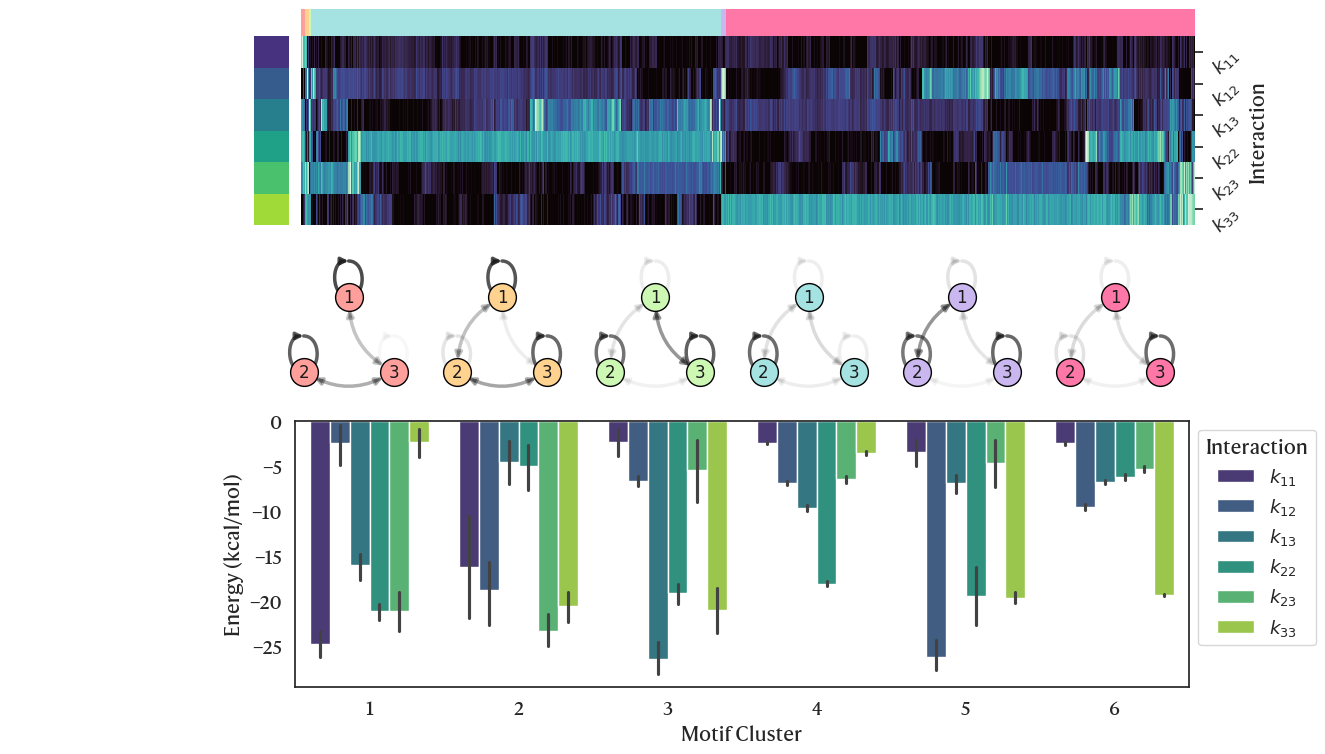

In [ ]:
# def plot_clusters(f_filt, save_name):
#     # sns.set_context("notebook", font_scale=1.4)
#     n_clusters = 6
#     custom_palette = sns.blend_palette(['#ff9f9b', '#ffb482', '#fffea3', '#c1f6b8', '#a0e7e0', '#b9d3ee', '#d6a4ef', '#ff77a7'], n_colors=n_clusters + 1)
#     figsize = (10, 9)

#     df_plot = pd.concat(
#         [data[f_filt(data)], data_sim[f_filt(data_sim)]], ignore_index=True)

#     g = sns.clustermap(data=df_plot[cols_e], col_cluster=False)
#     row_linkage = g.dendrogram_row.linkage
#     clusters = fcluster(row_linkage, t=n_clusters, criterion='maxclust')
#     df_plot['Cluster'] = clusters
#     lut = dict(zip(sorted(df_plot['Cluster'].unique()),
#                    custom_palette.as_hex()))
#     #    sns.color_palette('Spectral', n_clusters).as_hex()))
#     col_colors = df_plot['Cluster'].map(lut).to_numpy()
#     # row_colors = sns.color_palette('viridis', len(cols_e)).as_hex()

#     plt.close()
#     del g

#     g = sns.clustermap(data=df_plot[cols_e].T,
#                        cmap='mako_r', row_cluster=False, 
#                        cbar_pos=None,
#                        figsize=figsize,
#                     #    row_colors=row_colors,
#                        col_colors=col_colors,
#                        colors_ratio=0.15
#                        )
    
#     g.ax_col_dendrogram.set_visible(False)
    
#     g.ax_heatmap.set_xticklabels([])
#     g.ax_heatmap.set_xticks([])

#     g.ax_heatmap.set_ylabel('Interaction') 
#     g.ax_heatmap.set_yticklabels(cols_e, rotation=45)
#     g.gs.update(left=-0.235, right=0.95, bottom=0.6, top=0.9)

#     gs2 = matplotlib.gridspec.GridSpec(3, 1, left=0.05)
#     ax2 = g.figure.add_subplot(gs2[1])
#     ax3 = g.figure.add_subplot(gs2[2])

#     g2 = sns.barplot(data=df_plot.melt(id_vars=['Cluster'],
#                                        value_vars=cols_e,
#                                        value_name='Energy (kcal/mol)',
#                                        var_name='Interaction').sort_values('Interaction'),
#                      x='Cluster', y='Energy (kcal/mol)', hue='Interaction',
#                      ax=ax3, palette='viridis')
#     ax3.set_xlabel('Motif Cluster')
#     sns.move_legend(g2, "upper left", bbox_to_anchor=(1, 1)) 

#     ax2.set_axis_off()
#     pos = np.concatenate([(np.arange(n_clusters) / (n_clusters+1)) * 1.2 - 0.39,
#     # pos = np.concatenate([(np.arange(n_clusters) / (n_clusters+1)) * 1.11 - 0.39,
#                           np.ones(n_clusters) * - 0.1]).reshape(2, -1).T
#     colors = custom_palette.as_hex()
#     # colors = sns.color_palette('Spectral', n_clusters).as_hex()
#     for i, c in enumerate(sorted(df_plot['Cluster'].unique())):
#         fake_circuits_cluster = df_plot[df_plot['Cluster']
#                                         == c][cols_e].values
#         w = np.median(fake_circuits_cluster, axis=0)
#         create_network_inset(fig, ax2,
#                              pos=pos[i],
#                              width=0.9, height=0.9, edge_weights=make_nx_weights(w, n_nodes=3,
#                                                                                  vmin=np.min(df_plot[cols_e]), vmax=np.max(df_plot[cols_e])),
#                              node_color=colors[i], linewidth=2.5)

#     plt.tight_layout()
#     plt.savefig(os.path.join(
#         top_write_dir, f'{save_name}.png'), dpi=300, bbox_inches='tight', transparent=True)
#     # plt.savefig(os.path.join(
#     #     top_write_dir, f'{save_name}.svg'), bbox_inches='tight')

#     plt.show()

#     return df_plot


def f_filt_adapt(d): return (d['Log sensitivity'] > 0) & (d['Log precision'] > 1) & (
    np.isfinite(d['Log sensitivity'])) & (np.isfinite(d['Log precision']))


df_plot = plot_clusters(f_filt_adapt, 'motifs_cluster_bars2')

# Ruggedness

/tmp/ipykernel_255231/650455346.py:53: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g4 = sns.violinplot(data=df_plot, x='Cluster',
/tmp/ipykernel_255231/650455346.py:53: UserWarning: The palette list has more values (9) than needed (5), which may not be intended.
  g4 = sns.violinplot(data=df_plot, x='Cluster',
/tmp/ipykernel_255231/650455346.py:56: UserWarning: The palette list has more values (9) than needed (5), which may not be intended.
  g4 = sns.scatterplot(data=df_plot, x='Cluster 0', y='Log ruggedness (adaptation)', hue='Cluster', ax=ax4, palette=custom_palette,
/tmp/ipykernel_255231/650455346.py:75: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


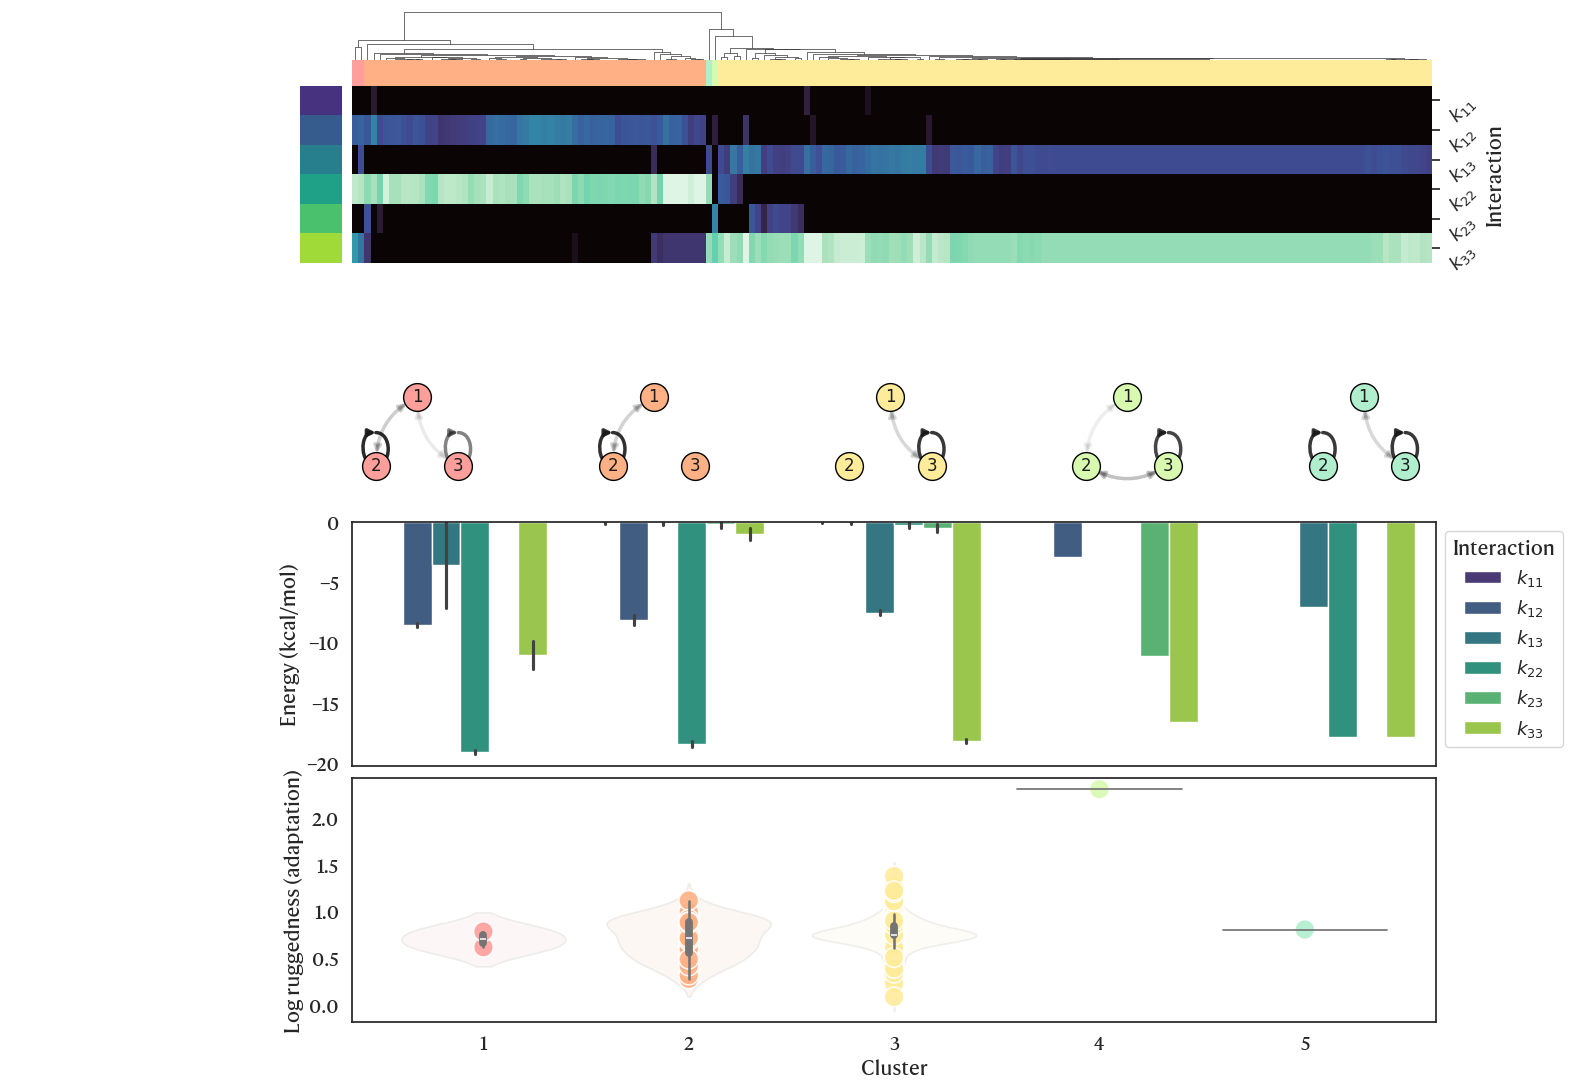

In [ ]:
def plot_clusters(f_filt, save_name):
    # sns.set_context("notebook", font_scale=1.2)
    n_clusters = 5
    figsize = (12, 11)

    df_plot = pd.concat(
        [data[f_filt(data)]], ignore_index=True)

    g = sns.clustermap(data=df_plot[cols_e], col_cluster=False)
    row_linkage = g.dendrogram_row.linkage
    clusters = fcluster(row_linkage, t=n_clusters, criterion='maxclust')
    df_plot['Cluster'] = clusters
    lut = dict(zip(sorted(df_plot['Cluster'].unique()),
                   custom_palette.as_hex()))
    #    sns.color_palette('Spectral', n_clusters).as_hex()))
    row_colors = df_plot['Cluster'].map(lut).to_numpy()
    col_colors = sns.color_palette('viridis', len(cols_e)).as_hex()

    plt.close()
    del g

    g = sns.clustermap(data=df_plot[cols_e].T,  # .rename(columns={c: ci for c, ci in zip(cols_e_bins, cols_e)}),
                       # 'label': 'Interaction energy differences'},
                       # cbar_kws={'orientation': 'vertical', 'shrink': 0.2},
                       cmap='mako_r', row_cluster=False,
                       cbar_pos=None,  # (0, .2, .03, .4), #standard_scale=1,
                       figsize=figsize,
                       row_colors=col_colors,
                       col_colors=row_colors,
                       colors_ratio=[0.03, 0.1]
                       )
    g.ax_heatmap.set_xticklabels([])
    g.ax_heatmap.set_xticks([])

    g.ax_heatmap.set_ylabel('Interaction')  # , fontsize=14)
    g.ax_heatmap.set_yticklabels(cols_e, rotation=45)
    g.gs.update(left=-0.235, right=0.95, bottom=0.75)

    gs2 = matplotlib.gridspec.GridSpec(4, 1, left=0.05, hspace=0.05)
    ax2 = g.figure.add_subplot(gs2[1])
    ax3 = g.figure.add_subplot(gs2[2])
    ax4 = g.figure.add_subplot(gs2[3])

    g2 = sns.barplot(data=df_plot.melt(id_vars=['Cluster'],
                                       value_vars=cols_e,
                                       value_name='Energy (kcal/mol)',
                                       var_name='Interaction').sort_values('Interaction'),
                     x='Cluster', y='Energy (kcal/mol)', hue='Interaction',
                     ax=ax3, palette='viridis')
    ax3.set_xlabel('Motif Cluster')
    sns.move_legend(g2, "upper left", bbox_to_anchor=(1, 1))  # , fontsize=14)

    g4 = sns.violinplot(data=df_plot, x='Cluster',
                        y='Log ruggedness (adaptation)', ax=ax4, palette=custom_palette, alpha=0.1)
    df_plot['Cluster 0'] = df_plot['Cluster'] - 1
    g4 = sns.scatterplot(data=df_plot, x='Cluster 0', y='Log ruggedness (adaptation)', hue='Cluster', ax=ax4, palette=custom_palette,
                         s=200, alpha=0.9, legend=False)

    # ax2.set_title('Interactions per cluster')
    ax2.set_axis_off()
    pos = np.concatenate([(np.arange(n_clusters) / (n_clusters+1)) * 1.31 - 0.39,
                          np.ones(n_clusters) * - 0.1]).reshape(2, -1).T
    colors = custom_palette.as_hex()
    # colors = sns.color_palette('Spectral', n_clusters).as_hex()
    for i, c in enumerate(sorted(df_plot['Cluster'].unique())):
        fake_circuits_cluster = df_plot[df_plot['Cluster']
                                        == c][cols_e].values
        w = np.median(fake_circuits_cluster, axis=0)
        create_network_inset(fig, ax2,
                             pos=pos[i],
                             width=0.9, height=0.9, edge_weights=make_nx_weights(w, n_nodes=3,
                                                                                 vmin=np.min(df_plot[cols_e]), vmax=np.max(df_plot[cols_e])),
                             node_color=colors[i], linewidth=2.5)

    plt.tight_layout()
    plt.savefig(os.path.join(
        top_write_dir, f'{save_name}.png'), dpi=300, bbox_inches='tight', transparent=True)
    plt.savefig(os.path.join(
        top_write_dir, f'{save_name}.svg'), bbox_inches='tight')

    plt.show()

    return df_plot


df_plot = plot_clusters(lambda d: (d['adaptation'] > 875) & (
    np.isfinite(d['Log sensitivity'])) & (np.isfinite(d['Log precision'])) , 'motifs_cluster_violins')


# UMAP

In [ ]:
# nrows = len(cols_e)
# cols = len(cols_e)
# fig, axes = plt.subplots(nrows, cols, figsize=(3*cols, 2*nrows))
# for i, (k1, k2) in enumerate(combos_e):
#     ax = axes[cols_e.index(k1), cols_e.index(k2)]
#     sns.histplot(data[filt], x=k1, y=k2, hue='Log sensitivity bin', palette='viridis', ax=ax, legend=False if i < len(combos_e) - 1 else True, alpha=0.5)
#     if ax.get_legend() is not None:
#         sns.move_legend(ax, 'upper left', bbox_to_anchor=(1, 1))
# plt.tight_layout()

In [ ]:
stop

In [20]:
def latin_hypercube_sampling(num_params, param_bounds, num_samples=1000):
    samples = np.zeros((num_samples, num_params))
    for i, (lower, upper) in enumerate(param_bounds):
        samples[:, i] = np.random.uniform(lower, upper, num_samples)
    
    # Shuffle to ensure stratified sampling
    for j in range(num_params):
        np.random.shuffle(samples[:, j])
    
    return samples

def reduce_dimensionality(df, n_components=2):
    X = df.values
    
    # Scale the data
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Apply UMAP
    np.random.seed(2)
    reducer = umap.UMAP(n_components=n_components,
                        n_neighbors=40,
                        init='pca',
                        min_dist=0.1,
                        n_jobs=16,
                        n_epochs=50)
    X_reduced = reducer.fit_transform(X_scaled.astype(np.float32))
    
    # Add reduced coordinates to original DataFrame
    df['UMAP 1'] = X_reduced[:, 0]
    df['UMAP 2'] = X_reduced[:, 1]
    
    return df

def cluster_parameter_groups(df, eps=0.5, cols=['UMAP 1', 'UMAP 2'], min_samples=5):
    clusterer = DBSCAN(eps=eps, min_samples=min_samples)
    df['cluster'] = clusterer.fit_predict(df[cols])
    
    return df

def visualize_results(df, hue='cluster'):
    fig = px.scatter(
        df, 
        x='UMAP 1', 
        y='UMAP 2', 
        color=hue, 
        hover_data=[col for col in df.columns if col.startswith('param_')],
        title='Parameter Space Exploration'
    )
    # Set square dimensions and adjust layout
    fig.update_layout(
        width=600,  # Equal width and height
        height=600,
        plot_bgcolor='white',
        paper_bgcolor='white',
        margin=dict(l=50, r=50, t=50, b=50)
    )
    return fig

# Create and run analysis
filt_d = (data['sample_name'] == 'RNA_2') # & (data['Log sensitivity'] > -5) & (data['Log sensitivity'] < 3) & (~data['Log precision'].isna())
# filt_d = filt_d & (data['Log sensitivity'] > 1)
results = data[filt_d][cols_e] #.iloc[:10000]
# results = data[filt_d][cols_e + ['Log sensitivity', 'Log precision', 'overshoot']].iloc[:10000]
reduced_results = reduce_dimensionality(results)
# clustered_results = cluster_parameter_groups(reduced_results, min_samples=100)
clustered_results = reduced_results
# visualization = visualize_results(clustered_results)
# visualization.show()

In [21]:
clustered_results.to_csv(os.path.join(top_write_dir, 'umap_clusters.csv'), index=False)

In [22]:
clustered_results['Log sensitivity'] = data[filt_d]['Log sensitivity']
clustered_results['Log precision'] = data[filt_d]['Log precision']
clustered_results['adaptation'] = data[filt_d]['adaptation']



In [27]:
for k in ['Log sensitivity', 'adaptation']:
    if f'{k} bin' in data:
        clustered_results[f'{k} bin'] = data[filt_d][f'{k} bin']
    else:
        clustered_results[f'{k} bin'] = pd.cut(clustered_results[k], bins=20)
        clustered_results[f'{k} bin'] = clustered_results[f'{k} bin'].apply(lambda x: np.round(x.mid, 1)).astype(float)

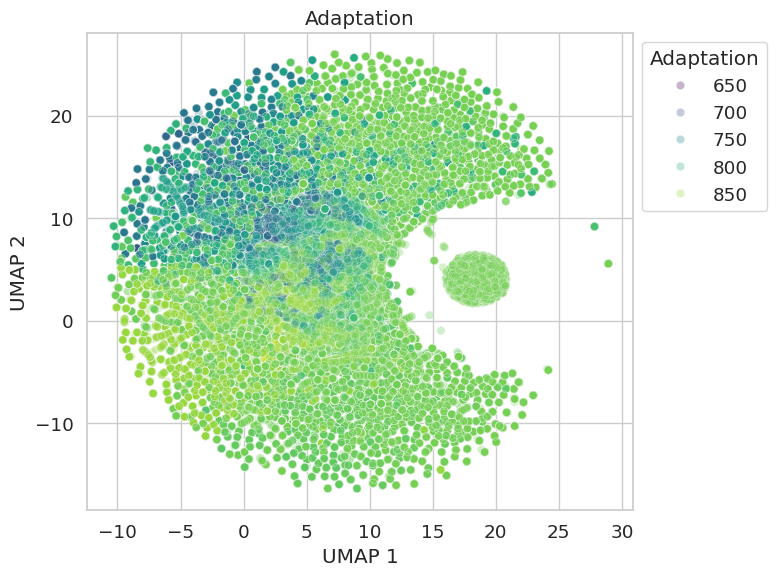

/tmp/ipykernel_2470596/4209060861.py:40: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  plt.tight_layout()


<Figure size 800x600 with 0 Axes>

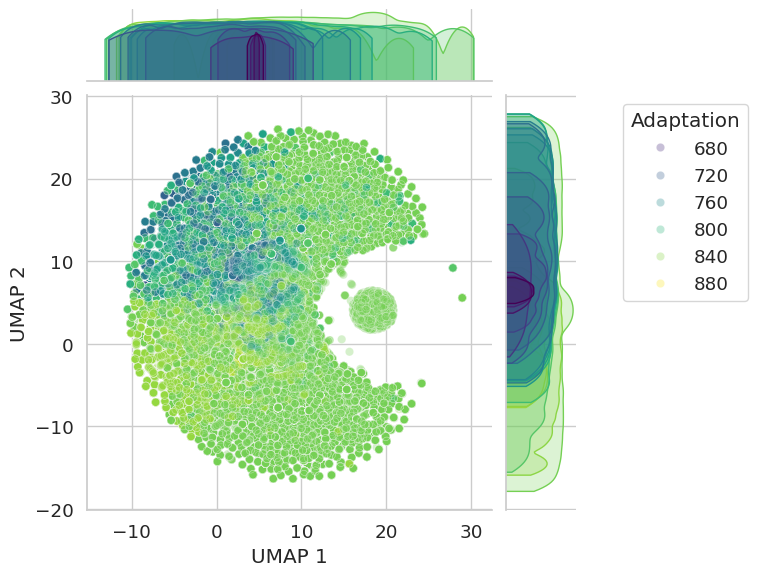

In [33]:
# sns.set_style('whitegrid')
# sns.set_context("notebook", font_scale=1.3)

if 'cluster' in clustered_results:
    fig, axs = plt.subplots(1, 2, figsize=(10, 4))
    sns.scatterplot(clustered_results, x='UMAP 1', y='UMAP 2', hue='cluster', palette='Spectral', ax=axs[0])
    axs[0].set_title('Clusters from UMAP')
    g = sns.scatterplot(clustered_results, x='UMAP 1', y='UMAP 2', hue='Log sensitivity', palette='Spectral', ax=axs[1], alpha=0.5)
    axs[1].set_title(f'$Log_{{10}}$ Sensitivity')
    sns.move_legend(g, 'upper left', bbox_to_anchor=(1, 1))
    plt.suptitle('DBSCAN Clustering of Parameter Space')
    plt.tight_layout()
    plt.savefig(os.path.join(top_write_dir, 'scatter_umap_clusters.png'), dpi=300, transparent=True)
    # plt.savefig(os.path.join(top_write_dir, 'scatter_umap_clusters.svg'))


sns.set_style('whitegrid')
for plot_set in ['scatter', 'joint']:
    
    k = 'adaptation'
    # hue = 'Log sensitivity bin' if plot_set == 'joint' else 'Log sensitivity'
    # title = f'$Log_{{10}}$ Sensitivity'
    hue = f'{k} bin' if plot_set == 'joint' else k
    title = k.capitalize().replace('Log', f'$Log_{{10}}$')
    f = sns.jointplot if plot_set == 'joint' else sns.scatterplot
    
    fig = plt.figure(figsize=(8, 6))
    g = f(clustered_results, x='UMAP 1', y='UMAP 2', hue=hue, palette='viridis', alpha=0.3)
    if plot_set == 'scatter': plt.title(title)
    plt.xlabel('UMAP 1')
    plt.ylabel('UMAP 2')
    sns.move_legend(g.ax_joint if plot_set == 'joint' else g, 'upper left', 
                    bbox_to_anchor=(1.3, 1) if plot_set == 'joint' else (1, 1), title=title)
    
    if plot_set == 'joint':
        # Set log scale on the *marginal histograms*
        g.ax_marg_x.set_yscale("log")  # horizontal histogram (log on count axis)
        g.ax_marg_y.set_xscale("log")  # vertical histogram
        g.ax_joint.set_alpha(0.3)

    plt.tight_layout()
    plt.savefig(os.path.join(top_write_dir, f'{plot_set}_umap_adaptation.png'), dpi=300, transparent=True)
    # plt.savefig(os.path.join(top_write_dir, f'{plot_set}_umap_sensitivity.svg'))
    plt.show()

In [ ]:
for fn, hue in zip(['sens', 'prec', 'adapt'], ['Log sensitivity', 'Log precision', 'adaptation']):
    fig = plt.figure(figsize=(10, 4))
    g = sns.scatterplot(clustered_results, x='UMAP 1', y='UMAP 2', hue=hue, palette='Spectral', alpha=0.5)
    plt.title(hue)
    sns.move_legend(g, 'upper left', bbox_to_anchor=(1, 1))
    plt.tight_layout()
    plt.savefig(os.path.join(top_write_dir, f'umap_{fn}.png'), dpi=300, transparent=True)
    # plt.savefig(os.path.join(top_write_dir, f'umap_{fn}.svg'))



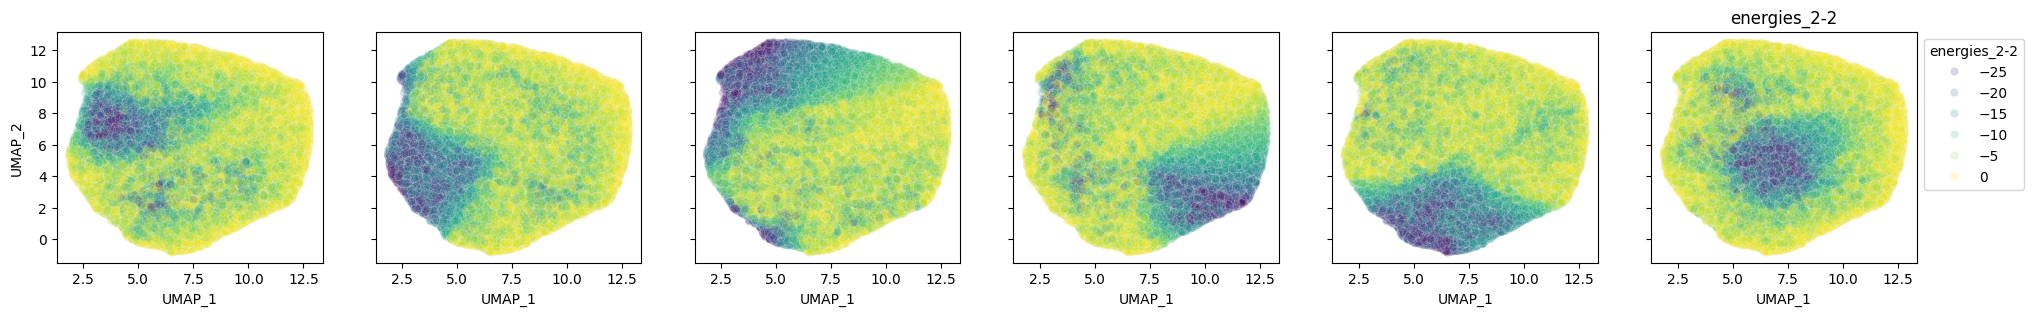

In [ ]:
clusters = sorted(clustered_results['cluster'].unique())
nrows = len(clusters)
ncols = len(cols_e)
fig, axs = plt.subplots(nrows, ncols, figsize=(4*ncols, 3*nrows), sharex=True, sharey=True)
if nrows == 1:
    axs = axs[None, :]
for ic, cluster in enumerate(clusters):
    for i, e_col in enumerate(cols_e):
        sns.scatterplot(clustered_results[clustered_results['cluster'] == cluster], x='UMAP 1', y='UMAP 2', hue=e_col, palette='viridis', alpha=0.2, ax=axs[ic, i], legend=False if i < len(cols_e) - 1 else True)
        axs[ic, i].set_title(e_col)
        if axs[ic, i].get_legend() is not None:
            sns.move_legend(axs[ic, i], 'upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
# plt.savefig(os.path.join(top_write_dir, 'umap_energies.png'), dpi=300, transparent=True)
plt.savefig(os.path.join(top_write_dir, 'umap_energies.svg'))

In [ ]:
# clusters = sorted(clustered_results['cluster'].unique())
# nrows = int(np.ceil(np.sqrt(len(clusters))))
# ncols = int(np.ceil(np.sqrt(len(clusters))))
# fig, axes = plt.subplots(nrows, ncols, figsize=(4*ncols, 3*nrows))
# for i, cluster in enumerate(clusters):
#     ax = axes.flatten()[i]
#     filt = clustered_results['cluster'] == cluster
#     sns.histplot(clustered_results[filt], x='Log sensitivity', y='Log precision', ax=ax)
#     ax.set_xlim(clustered_results['Log sensitivity'].min(), clustered_results['Log sensitivity'].max())
#     ax.set_ylim(clustered_results['Log precision'].min(), clustered_results['Log precision'].max())
#     ax.set_title(f'Cluster {cluster}')
# plt.tight_layout()

In [ ]:
# nrows = len(cols_e)
# cols = len(cols_e)
# fig, axes = plt.subplots(nrows, cols, figsize=(3*cols, 2*nrows))
# for i, (k1, k2) in enumerate(combos_e):
#     ax = axes[cols_e.index(k1), cols_e.index(k2)]
#     c_i = clustered_results[clustered_results['cluster'] == 14]
#     sns.histplot(c_i, x=k1, y=k2, hue='cluster', palette='viridis', ax=ax, legend=False if i < len(combos_e) - 1 else True, alpha=0.5)
#     if ax.get_legend() is not None:
#         sns.move_legend(ax, 'upper left', bbox_to_anchor=(1, 1))
# plt.tight_layout()

: 